In [2]:
import pandas as pd
import numpy as np
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

In [3]:
df = pd.read_csv('psp_csv_data\PSP_Example.csv')

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df.columns
df.describe()

,v_perp_0,v_para,v_perp_1,f(v)
count,2048.000000,2048.000000,2048.000000,2048.000000
mean,-53.939760,39.440815,-464.798314,0.194035
std,428.435771,288.805652,390.728978,1.911248
min,-1622.942876,-1061.088543,-1852.323186,0.000000
25%,-223.058086,-82.167513,-671.040493,0.000000
50%,-27.770908,21.639999,-322.979434,0.000000
75%,132.488211,143.756709,-155.381037,0.000000
max,1431.579386,1299.948769,-37.930043,43.084849


In [6]:

vp0 = df["v_perp_0"].to_numpy()
vp1 = df["v_perp_1"].to_numpy()
vpa = df["v_para"].to_numpy()
fval = df["f(v)"].to_numpy()

In [7]:
df.describe()

,v_perp_0,v_para,v_perp_1,f(v)
count,2048.000000,2048.000000,2048.000000,2048.000000
mean,-53.939760,39.440815,-464.798314,0.194035
std,428.435771,288.805652,390.728978,1.911248
min,-1622.942876,-1061.088543,-1852.323186,0.000000
25%,-223.058086,-82.167513,-671.040493,0.000000
50%,-27.770908,21.639999,-322.979434,0.000000
75%,132.488211,143.756709,-155.381037,0.000000
max,1431.579386,1299.948769,-37.930043,43.084849


In [8]:
fig = go.Figure(data=go.Scatter3d(
    x=vp0,
    y=vp1,
    z=vpa,
    mode='markers',
    marker=dict(
        size=4,
        color=fval,
        colorscale='Plasma',
        opacity=0.8,
        colorbar=dict(
            title=dict(text='f(v)', side='right'),
            thickness=20,
            tickfont=dict(size=14)
        )
    )
))

fig.update_layout(
    title=dict(
        text='<b>Solar Wind Velocity Distribution Function f(v)</b><br><sup>Parker Solar Probe (SPAN-I)</sup>',
        x=0.5,
        xanchor='center',
        font=dict(size=22)
    ),
    scene=dict(
        xaxis=dict(
            title=dict(text='v<sub>⊥0</sub> [km/s]', font=dict(size=18)),
            tickfont=dict(size=14),
            backgroundcolor='white',
            gridcolor='lightgray',
            zerolinecolor='gray',
            showbackground=True
        ),
        yaxis=dict(
            title=dict(text='v<sub>⊥1</sub> [km/s]', font=dict(size=18)),
            tickfont=dict(size=14),
            backgroundcolor='white',
            gridcolor='lightgray',
            zerolinecolor='gray',
            showbackground=True
        ),
        zaxis=dict(
            title=dict(text='v<sub>∥</sub> [km/s]', font=dict(size=18)),
            tickfont=dict(size=14),
            backgroundcolor='white',
            gridcolor='lightgray',
            zerolinecolor='gray',
            showbackground=True
        ),
        aspectmode='cube',
        camera=dict(eye=dict(x=1.4, y=1.4, z=1.1))
    ),
    margin=dict(l=0, r=0, t=80, b=0),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig.show()



In [9]:
vp0p = np.array(vp0)
vp1p = np.array(vp1)

fval_copy = np.array(fval, dtype=np.float64)
fval_copy[fval_copy == 0] = 1

denom = np.sum(fval_copy)
p_i = fval_copy / denom 
    
n = 5000
s = n * p_i
samples = np.round(s).astype(int)

# say sample = [3, 0, 2] and vp0p = [10, 20, 30] then v_sampled_0 = [10, 10, 10, 30, 30]

v_sampled_0 = np.repeat(vp0p, samples)
v_sampled_1 = np.repeat(vp1p, samples)
v_sampled_para = np.repeat(vpa, samples)



In [10]:
sample_data = {'v_perp_0': v_sampled_0, 'v_perp_1': v_sampled_1, 'v_para': v_sampled_para}
sample_df = pd.DataFrame(sample_data)

sample_df.to_csv('PSP_sampled.csv', index=False)

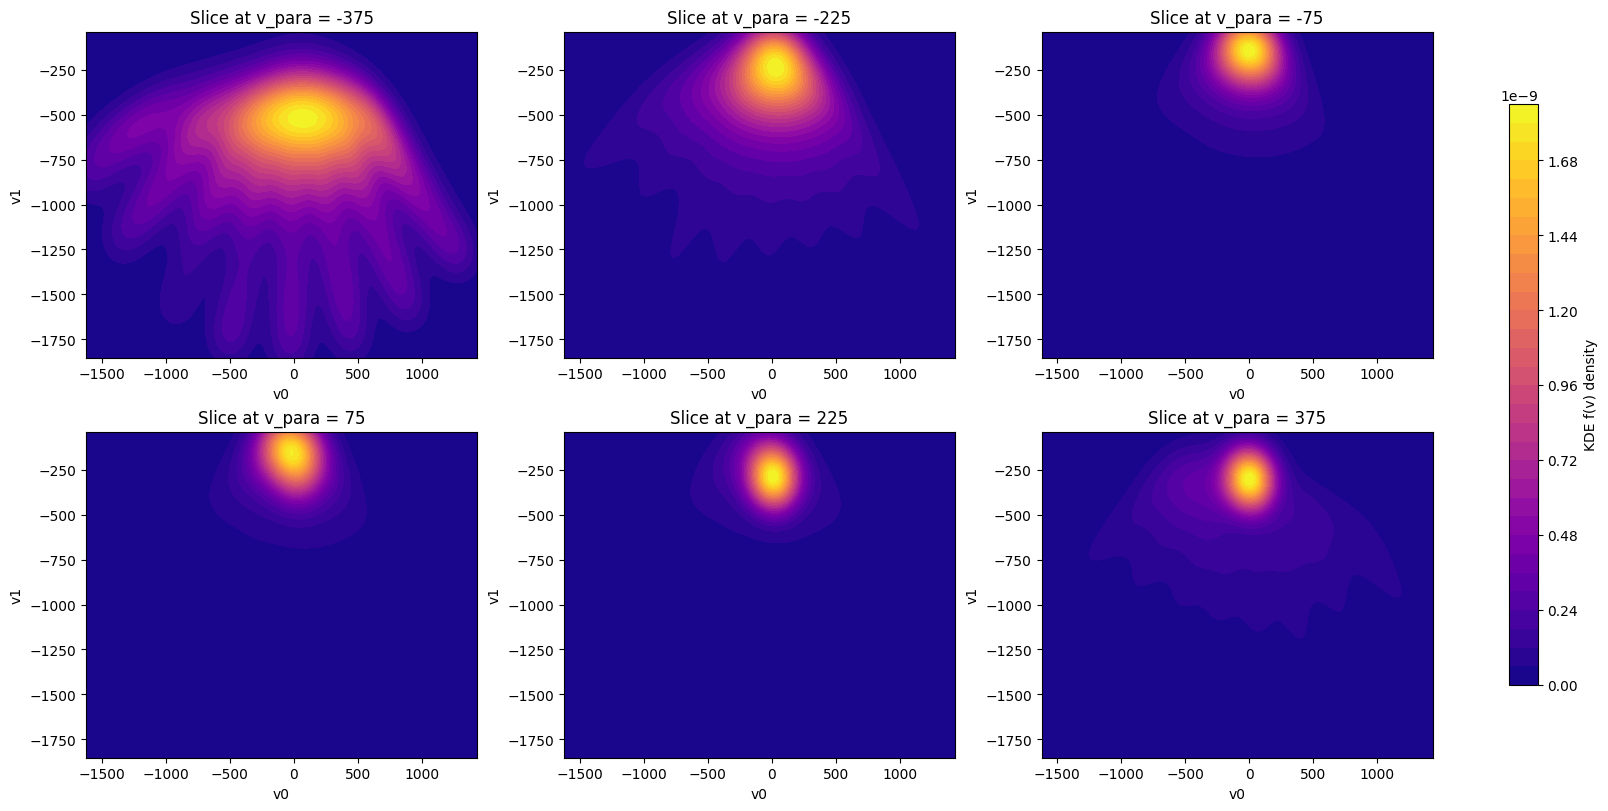

In [11]:
data = np.vstack([v_sampled_0, v_sampled_1, v_sampled_para])
kde = gaussian_kde(data)

c_values = [-375, -225, -75, 75, 225, 375] # slice level for v_para


v0_grid, v1_grid = np.mgrid[
    v_sampled_0.min():v_sampled_0.max():100j,
    v_sampled_1.min():v_sampled_1.max():100j
]


fig, axes = plt.subplots(2, 3, figsize=(16, 8), constrained_layout=True)
axes = axes.ravel()

for i, c in enumerate(c_values):

    coords = np.vstack([
        v0_grid.ravel(),
        v1_grid.ravel(),
        np.full(v0_grid.size, c)
    ])
    dens_slice = kde(coords).reshape(v0_grid.shape)

    ax = axes[i]
    contour = ax.contourf(v0_grid, v1_grid, dens_slice, levels=30, cmap="plasma")

    ax.set_title(f"Slice at v_para = {c}")
    ax.set_xlabel("v0")
    ax.set_ylabel("v1")

fig.colorbar(contour, ax=axes, orientation="vertical", shrink=0.8, label="KDE f(v) density")

plt.show()



In [12]:
v0_min, v0_max = v_sampled_0.min(), v_sampled_0.max()
v1_min, v1_max = v_sampled_1.min(), v_sampled_1.max()

V0, V1 = np.meshgrid(
    np.linspace(v0_min, v0_max, 100),
    np.linspace(v1_min, v1_max, 100)
)

fig = go.Figure()

for c in c_values:
    coords = np.vstack([
        V0.ravel(),
        V1.ravel(),
        np.full(V0.size, c)
    ])
    dens_slice = kde(coords).reshape(V0.shape)

    fig.add_trace(go.Surface(
        x=V0,
        y=V1,
        z=np.full_like(V0, c),
        surfacecolor=dens_slice,
        colorscale="Plasma",
        showscale=False,
        opacity=0.85,
        contours=dict(
            x=dict(show=True, color="black", width=1),
            y=dict(show=True, color="black", width=1),
            z=dict(show=False)
        )
    ))

fig.update_layout(
    title="3D KDE Slices Across v_parallel",
    scene=dict(
        xaxis_title="v0",
        yaxis_title="v1",
        zaxis_title="v_parallel",
        aspectratio=dict(x=1, y=1, z=1.2)
    ),
    width=950,
    height=850
)